In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [23]:
def load_data(path: str):
    df = pd.read_excel(path)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.set_index('Date')
    df.index = pd.to_datetime(df.index)
    return df

In [24]:
df = load_data('sales forecast problem.xlsx')

### Overview the data

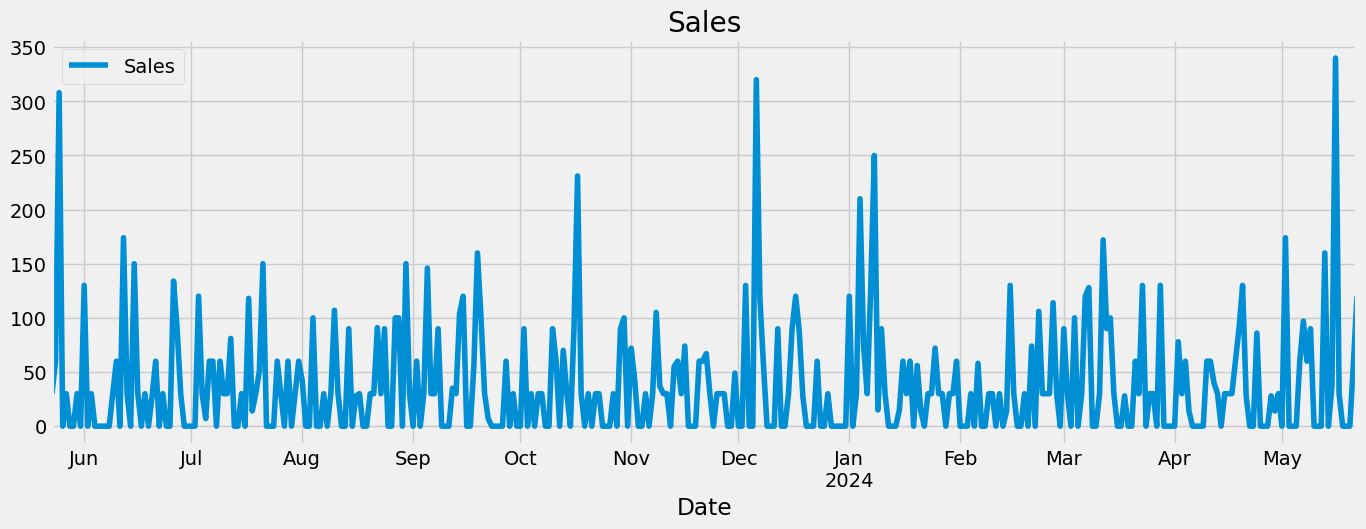

In [25]:
df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='Sales')
plt.show()

### Train/Test split

At first, let's devide the data and plot the result

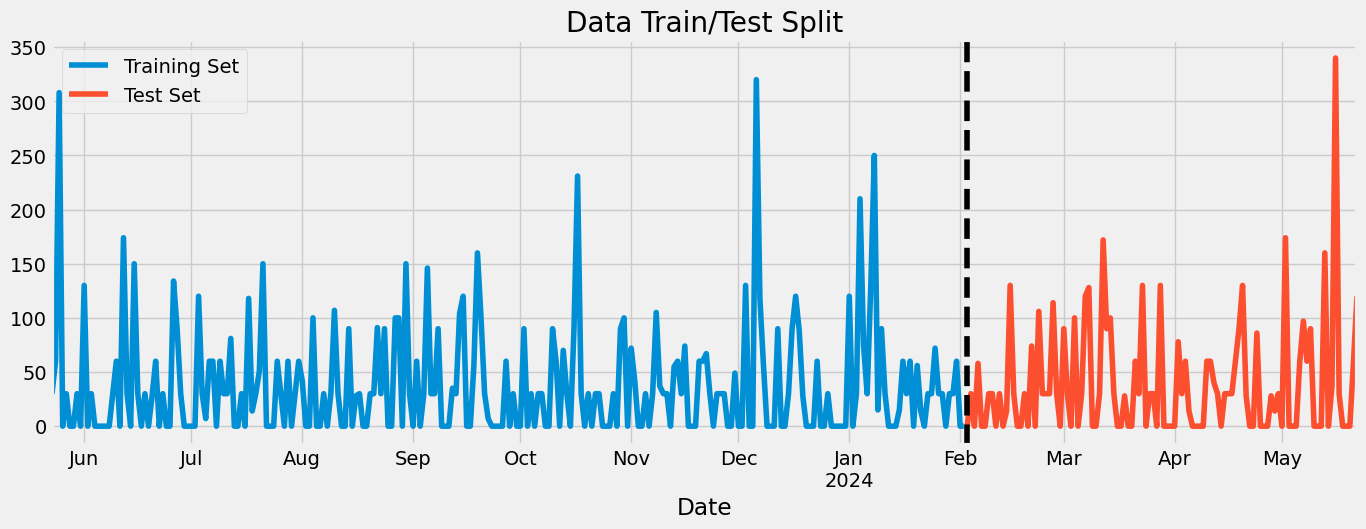

In [26]:
split_index = int(0.7 * len(df))

# Split data into training and testing sets
train = df.iloc[:split_index]
test = df.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(df.index[split_index], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

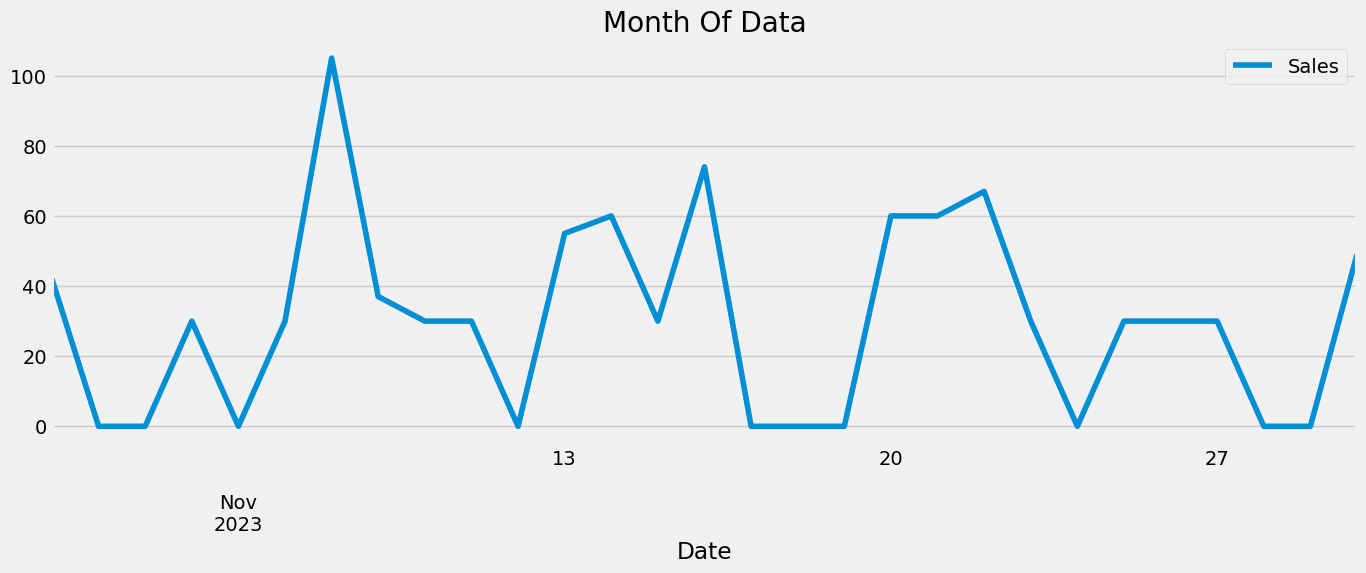

In [27]:
df.loc[(df.index > '11.01.2023') & (df.index < '12.01.2023')].plot(figsize=(15, 5), title='Month Of Data')
plt.show()

### Feature Creation

In [28]:
def create_features(df):
    ###Create time series features based on time series index
    df = df.copy()
    df['Year'] = df.index.year
    df['Month'] = df.index.month_name()
    df['Day'] = df.index.day
    df['Weekday'] = df.index.day_name()
    df['Week'] = df.index.isocalendar().week
    df['Quarter'] = df.index.quarter.astype('str')
    df['Day_of_Year'] = df.index.dayofyear
    df['Is_Month_Start'] = df.index.is_month_start
    df['Is_Month_End'] = df.index.is_month_end
    df['Part_of_month'] = df.index.to_series().apply(lambda x: 0 if x.day >= 15 else 1)
    df['Is_weekend'] = df.index.to_series().apply(lambda x: 1 if x.weekday() >= 5 else 0)   
    return df

df = create_features(df)

In [29]:
df.head()

,Sales,Year,Month,Day,Weekday,Week,Quarter,Day_of_Year,Is_Month_Start,Is_Month_End,Part_of_month,Is_weekend
Date,,,,,,,,,,,,
2023-05-23,30,2023,May,23,Tuesday,21,2,143,False,False,0,0
2023-05-24,60,2023,May,24,Wednesday,21,2,144,False,False,0,0
2023-05-25,308,2023,May,25,Thursday,21,2,145,False,False,0,0
2023-05-26,0,2023,May,26,Friday,21,2,146,False,False,0,0
2023-05-27,30,2023,May,27,Saturday,21,2,147,False,False,0,1


### Visualize our Feature / Target Relationship

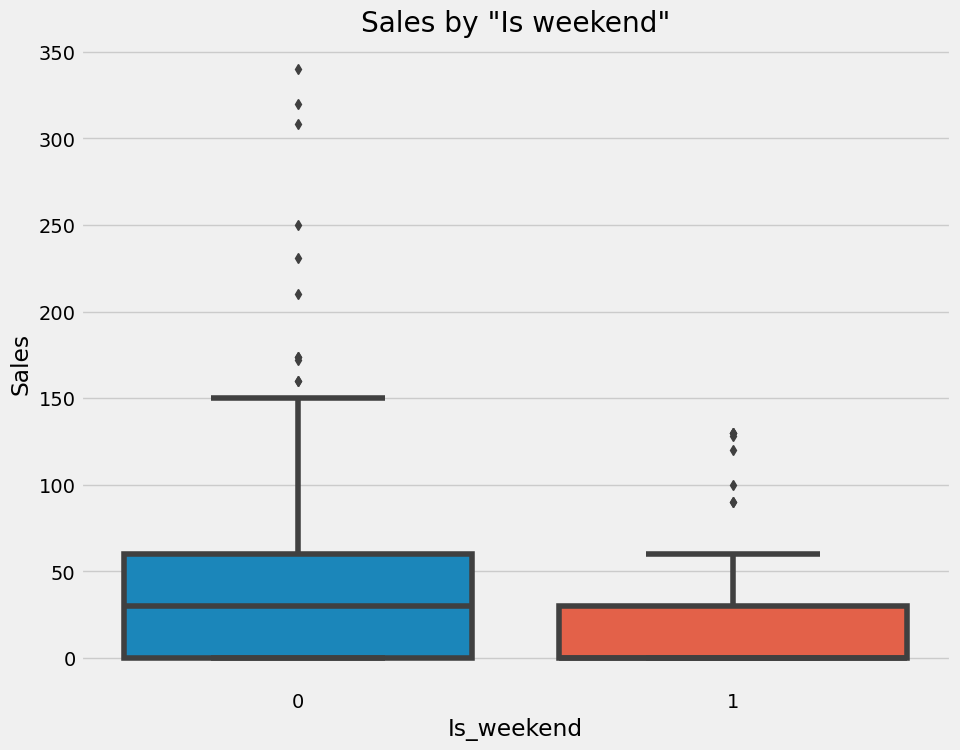

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Is_weekend', y='Sales')
ax.set_title('Sales by "Is weekend"')
plt.show()

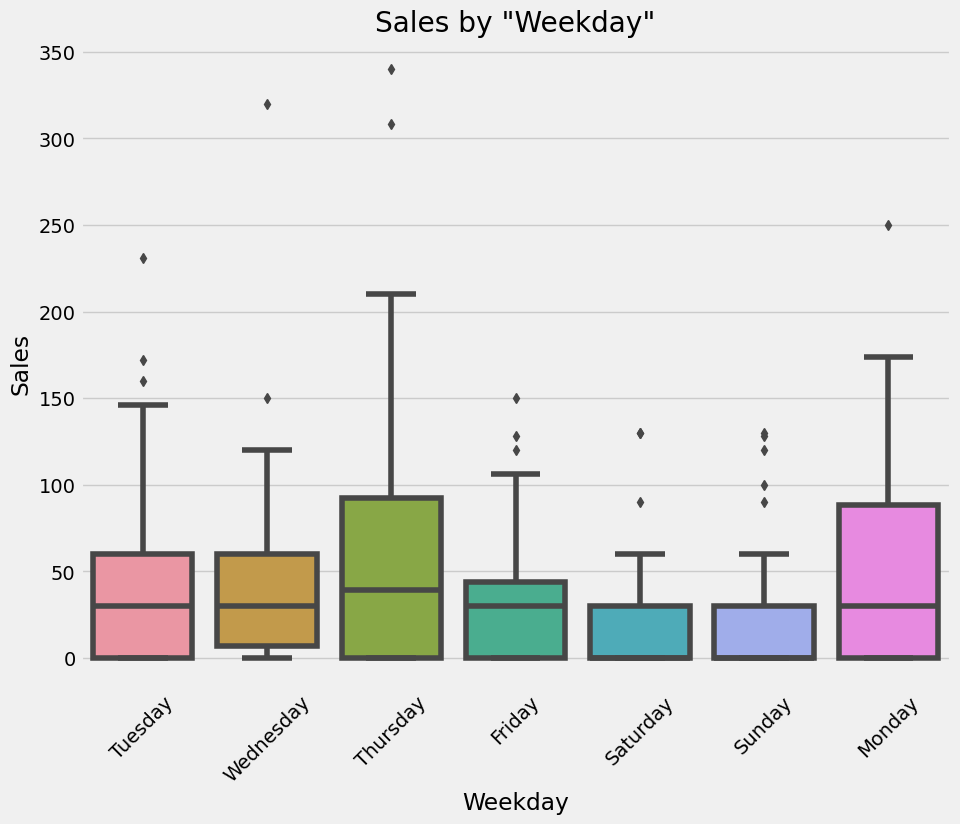

In [31]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Weekday', y='Sales')
ax.set_title('Sales by "Weekday"')
plt.xticks(rotation=45)
plt.show()

### Encode categorical features using TargetEncoder

In [32]:
from category_encoders import TargetEncoder

train = create_features(train)
test = create_features(test)

encoder = TargetEncoder(cols=['Weekday', 'Month', 'Quarter'])

train = encoder.fit_transform(train, train['Sales'])
test = encoder.transform(test)

### Create our Model

In [33]:
X_train = train.drop('Sales', axis=1)
y_train = train['Sales']

X_test = test.drop('Sales', axis=1)
y_test = test['Sales']

In [34]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 110 entries, 2024-02-03 to 2024-05-22
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            110 non-null    int32  
 1   Month           110 non-null    float64
 2   Day             110 non-null    int32  
 3   Weekday         110 non-null    float64
 4   Week            110 non-null    UInt32 
 5   Quarter         110 non-null    float64
 6   Day_of_Year     110 non-null    int32  
 7   Is_Month_Start  110 non-null    bool   
 8   Is_Month_End    110 non-null    bool   
 9   Part_of_month   110 non-null    int64  
 10  Is_weekend      110 non-null    int64  
dtypes: UInt32(1), bool(2), float64(3), int32(3), int64(2)
memory usage: 7.2 KB


In [35]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1500,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:62.90579	validation_1-rmse:65.42276
[100]	validation_0-rmse:48.86024	validation_1-rmse:53.94178
[200]	validation_0-rmse:45.53354	validation_1-rmse:51.99899
[300]	validation_0-rmse:43.06653	validation_1-rmse:51.65582
[400]	validation_0-rmse:40.38999	validation_1-rmse:51.55437
[500]	validation_0-rmse:38.40555	validation_1-rmse:51.44149
[600]	validation_0-rmse:37.14809	validation_1-rmse:51.30514
[700]	validation_0-rmse:35.98567	validation_1-rmse:51.24147
[800]	validation_0-rmse:34.90800	validation_1-rmse:51.08028
[900]	validation_0-rmse:34.13901	validation_1-rmse:50.93723
[1000]	validation_0-rmse:33.23395	validation_1-rmse:50.73211
[1055]	validation_0-rmse:32.81703	validation_1-rmse:50.74858


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance

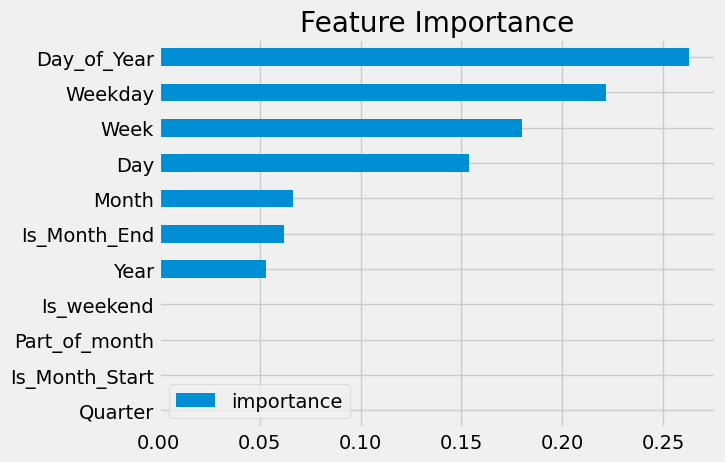

In [36]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on Test

In [37]:
test['prediction'] = reg.predict(X_test)
train['prediction'] = reg.predict(X_train)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

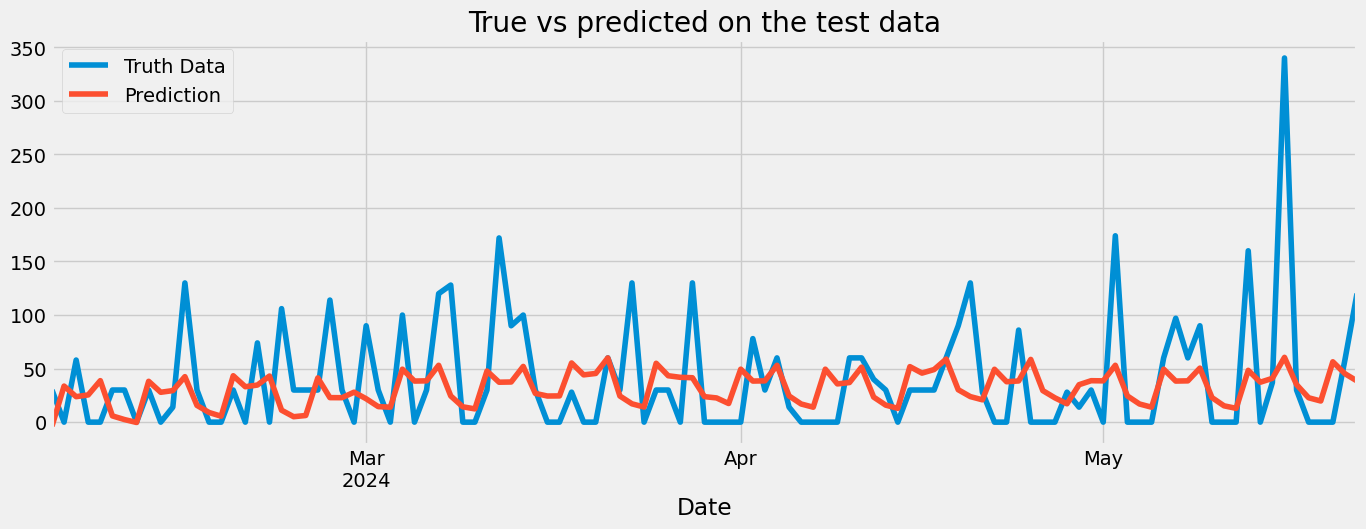

In [38]:
ax = df.loc[df.index > df.index[split_index]]['Sales'].plot(figsize=(15, 5), title='True vs predicted on the test data')
df.loc[df.index > df.index[split_index]]['prediction'].plot(style='-')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [39]:
mse_train = mean_squared_error(y_train, train['prediction'])
mse_test = mean_squared_error(y_test, test['prediction'])

print(f'Mean Squared Error (train): {mse_train}')
print(f'Mean Squared Error (test): {mse_test}')

Mean Squared Error (train): 1102.4085487503978
Mean Squared Error (test): 2571.849600997431


### What next?

Add more features (weather forecast, holida, specific domain informationy
Search for the best params of the regressors)